# Python Interface For CAFFE

#### python包：
包是一个包含__init__.py 文件的目录，该目录下一定得有这个__init__.py文件和其它模块或子包。
#### python模块：
自我包含并且有组织的代码片段为模块。
表现形式为：写的代码保存为文件。这个文件就是一个模块。sample.py 其中文件名smaple为模块名字。

<img src="pycaffe.png"
style="width:1638px;height:120px;float:left">

#### Set up path

In [1]:
caffe_root = '/home/zhangdanfeng/caffe-c/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
#-------------------------------------------------#
#from .proto.caffe_pb2 import TRAIN, TEST
#from .net_spec import layers, params, NetSpec, to_proto

#from .pycaffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, RMSPropSolver, AdaDeltaSolver, AdamSolver
#from ._caffe import set_mode_cpu, set_mode_gpu, set_device, Layer, get_solver, layer_type_list, set_random_seed

#from .classifier import Classifier
#from .detector import Detector
#from . import io
#-------------------------------------------------#
from caffe.proto import caffe_pb2
from google.protobuf import text_format
#-------------------------------------------------#
import numpy as np
from pylab import *
import tempfile
%matplotlib inline

## 1 Net Parameter
from .proto.caffe_pb2 import TRAIN, TEST

from .net_spec import layers, params, NetSpec, to_proto

##### proto.caffe_pb2 -> TRAIN, TEST

<img src="machine-learning-training-prediction-2.png"
style="width:548px;height:247px;float:left">

##### net_spec -> layers, params, NetSpec, to_proto

In [2]:
from caffe import layers as L
from caffe import params as P
def lenet(batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.DummyData(shape=[dict(dim=[batch_size, 1, 28, 28]),
                                         dict(dim=[batch_size, 1, 1, 1])],
                                  transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20,
        weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50,
        weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500,
        weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=10,
        weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
net_proto = lenet(32)
net_proto_file = 'test_lenet.prototxt'
with open(net_proto_file,'w') as net_f :
    net_f.write(str(net_proto))

In [3]:
#!cat test_lenet.prototxt

#### Read prototxt into a caffe.pb2.Netparameter
netSpec.to_proto()---->>Netparameter

In [4]:
sample_netparam = 'train_val_inception_3b.prototxt'
net_param = caffe_pb2.NetParameter()
flag = text_format.Merge(open(sample_netparam).read(),net_param)

#### Draw the net [LR TD DT]

<img src="GoogleNetTD.png"
style="width:150px;height:464px;float:left">

#### Redefine the net work
Set the lr of the layers before innerproduct to zero , and write it to a temp file or a real file

In [5]:
#fix the lr
#print dir(net_param.layer[0])
for ith_layer in net_param.layer:
    if ith_layer.type == 'InnerProduct' :
        break
    else :
        for params in ith_layer.param:
            if params:
                params.lr_mult = 0

#set the data layer 
net_param.layer[0].data_param.source = '/ssd/zhangdanfeng/char_data/train_bank_card_chars/step2/img_train_lmdb'
net_param.layer[0].transform_param.mean_file = '/ssd/zhangdanfeng/char_data/train_bank_card_chars/step2/mean.binaryproto'
net_param.layer[1].data_param.source = '/ssd/zhangdanfeng/char_data/test_real_bankcard/img_test_lmdb'
net_param.layer[1].transform_param.mean_file = '/ssd/zhangdanfeng/char_data/test_real_bankcard/mean.binaryproto'

#renamne the innerproduct layer
net_param.layer[-3].name = net_param.layer[-3].name + '/new'
net_param.layer[-6].name = net_param.layer[-6].name + '/new'
net_param.layer[-7].name = net_param.layer[-7].name + '/new'
#eval exec

#write protobuf to file
with tempfile.NamedTemporaryFile(delete=False) as net_f:
    net_f.write(str(net_param))
print net_f.name

/tmp/tmpDiYEFx


In [6]:
#!cat /tmp/tmpsPIC4B

## 2)Net & Solver
from .pycaffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, RMSPropSolver, AdaDeltaSolver, AdamSolver

from ._caffe import set_mode_cpu, set_mode_gpu, set_device, Layer, get_solver, layer_type_list, set_random_seed

#### Set the computation mode CPU

In [7]:
caffe.set_mode_cpu()

#### Or GPU

In [8]:
caffe.set_device(0)
caffe.set_mode_gpu()

#### Init a net

In [9]:
weightfile = 'prefix_iter_380_50er.caffemodel'
net = caffe.Net(sample_netparam, weightfile, caffe.TEST)
#net.set_mode_gpu()
#net.set_phase_test()
#net.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy'))  # ImageNet mean
#net.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
#net.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

<img src="netblob.png"
style="width:550px;height:630px;float:left">

In [10]:
print [layertype for layertype in caffe.layer_type_list()]

['AbsVal', 'Accuracy', 'ArgMax', 'BN', 'BNLL', 'BatchNorm', 'BatchReindex', 'Concat', 'ContrastiveLoss', 'Convolution', 'Data', 'Deconvolution', 'Dropout', 'DummyData', 'Eltwise', 'Embed', 'EuclideanLoss', 'Exp', 'Filter', 'Flatten', 'HDF5Data', 'HDF5Output', 'HingeLoss', 'Im2col', 'ImageData', 'InfogainLoss', 'InnerProduct', 'LRN', 'Log', 'MVN', 'MemoryData', 'MultinomialLogisticLoss', 'PReLU', 'Pooling', 'Power', 'Python', 'ReLU', 'Reduction', 'Reshape', 'SPP', 'Sigmoid', 'SigmoidCrossEntropyLoss', 'Silence', 'Slice', 'Softmax', 'SoftmaxWithLoss', 'Split', 'TanH', 'Threshold', 'Tile', 'WindowData']


#### weight and biaes shape

In [11]:
print "weight sizes"
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]

weight sizes


[('conv1/7x7_s2', (64, 1, 7, 7), (64,)),
 ('conv1/7x7_s2_bn', (1, 64, 1, 1), (1, 64, 1, 1)),
 ('conv2/3x3_reduce', (64, 64, 1, 1), (64,)),
 ('conv2/3x3_reduce_bn', (1, 64, 1, 1), (1, 64, 1, 1)),
 ('conv2/3x3', (192, 64, 3, 3), (192,)),
 ('conv2/3x3_bn', (1, 192, 1, 1), (1, 192, 1, 1)),
 ('inception_3a/3x3_reduce', (96, 192, 1, 1), (96,)),
 ('inception_3a/3x3_reduce_bn', (1, 96, 1, 1), (1, 96, 1, 1)),
 ('inception_3a/3x3', (128, 96, 3, 3), (128,)),
 ('inception_3a/3x3_bn', (1, 128, 1, 1), (1, 128, 1, 1)),
 ('inception_3a/5x5_reduce', (16, 192, 1, 1), (16,)),
 ('inception_3a/5x5_reduce_bn', (1, 16, 1, 1), (1, 16, 1, 1)),
 ('inception_3a/5x5_1', (32, 16, 3, 3), (32,)),
 ('inception_3a/5x5_1_bn', (1, 32, 1, 1), (1, 32, 1, 1)),
 ('inception_3a/5x5', (32, 32, 3, 3), (32,)),
 ('inception_3a/5x5_bn', (1, 32, 1, 1), (1, 32, 1, 1)),
 ('inception_3a/pool_proj', (32, 192, 1, 1), (32,)),
 ('inception_3a/pool_proj_bn', (1, 32, 1, 1), (1, 32, 1, 1)),
 ('inception_3b/3x3_reduce', (128, 192, 1, 1), (12

In [12]:
layer_name = []
for ith_layer in net_param.layer:
    if ith_layer.type == 'Convolution':
        layer_name.append(str(ith_layer.name))
params_full = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in layer_name}
[(_params, params_full[_params][0].shape, params_full[_params][1].shape) for _params in params_full]

[('inception_3a/3x3_reduce', (96, 192, 1, 1), (96,)),
 ('inception_3a/5x5_reduce', (16, 192, 1, 1), (16,)),
 ('conv2/3x3', (192, 64, 3, 3), (192,)),
 ('inception_3b/5x5_1', (96, 32, 3, 3), (96,)),
 ('conv1/7x7_s2', (64, 1, 7, 7), (64,)),
 ('inception_3a/5x5_1', (32, 16, 3, 3), (32,)),
 ('inception_3b/3x3_reduce', (128, 192, 1, 1), (128,)),
 ('loss_3b/conv', (128, 480, 1, 1), (128,)),
 ('inception_3b/3x3', (192, 128, 3, 3), (192,)),
 ('inception_3b/5x5', (96, 96, 3, 3), (96,)),
 ('conv2/3x3_reduce', (64, 64, 1, 1), (64,)),
 ('inception_3a/5x5', (32, 32, 3, 3), (32,)),
 ('inception_3a/pool_proj', (32, 192, 1, 1), (32,)),
 ('inception_3b/5x5_reduce', (32, 192, 1, 1), (32,)),
 ('inception_3a/3x3', (128, 96, 3, 3), (128,))]

#### Output shape

In [13]:
print('each output is (batch size, feature dim, spatial dim)')
[(k, v.data.shape) for k, v in net.blobs.items()]

each output is (batch size, feature dim, spatial dim)


[('data', (100, 1, 64, 64)),
 ('label', (100,)),
 ('label_data_1_split_0', (100,)),
 ('label_data_1_split_1', (100,)),
 ('conv1/7x7_s2', (100, 64, 30, 30)),
 ('conv1/7x7_s2_bn', (100, 64, 30, 30)),
 ('conv1/relu_7x7', (100, 64, 30, 30)),
 ('pool1/3x3_s2', (100, 64, 15, 15)),
 ('conv2/3x3_reduce', (100, 64, 15, 15)),
 ('conv2/3x3_reduce_bn', (100, 64, 15, 15)),
 ('conv2/relu_3x3_reduce', (100, 64, 15, 15)),
 ('conv2/3x3', (100, 192, 15, 15)),
 ('conv2/3x3_bn', (100, 192, 15, 15)),
 ('conv2/relu_3x3', (100, 192, 15, 15)),
 ('pool2/3x3_s2', (100, 192, 7, 7)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_0', (100, 192, 7, 7)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_1', (100, 192, 7, 7)),
 ('pool2/3x3_s2_pool2/3x3_s2_0_split_2', (100, 192, 7, 7)),
 ('inception_3a/3x3_reduce', (100, 96, 7, 7)),
 ('inception_3a/3x3_reduce_bn', (100, 96, 7, 7)),
 ('inception_3a/relu_3x3_reduce', (100, 96, 7, 7)),
 ('inception_3a/3x3', (100, 128, 7, 7)),
 ('inception_3a/3x3_bn', (100, 128, 7, 7)),
 ('inception_3a/relu_3x

#### First layer filters, conv1/7x7_s2

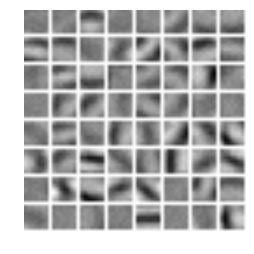

In [14]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data,'gray'); plt.axis('off')
# the parameters are a list of [weights, biases]
filters = net.params['conv1/7x7_s2'][0].data
vis_square(filters.transpose(0, 2, 3, 1).reshape(filters.shape[0],filters.shape[2],filters.shape[3]))

#### Forward for one time

In [15]:
net.forward()

{'accuracy': array(0.949999988079071, dtype=float32),
 'loss': array(0.15718066692352295, dtype=float32)}

test results: [0, 0, 0, 0, 0, 0, 0, 4, 0, 0]


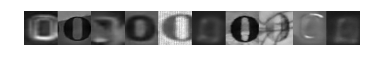

In [16]:
prob = net.blobs["loss_3b/classifier"].data[:10,:]
predict_result = [prob[i].argmax() for i in range(10)]
imshow(net.blobs['data'].data[:10, 0].transpose(1, 0, 2).reshape(64, 10*64), cmap='gray'); axis('off')
#print 'test labels:', net.blobs['label'].data[:8]
print 'test results:', predict_result

#### First layer outputs, conv1/7x7_s2

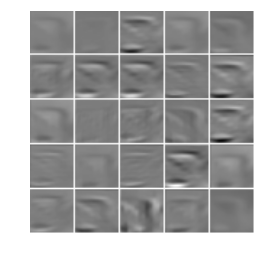

In [17]:
feat = net.blobs['conv1/7x7_s2'].data[2, :25]
vis_square(feat)

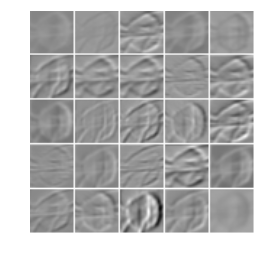

In [18]:
feat = net.blobs['conv1/7x7_s2'].data[7, :25]
vis_square(feat)

#### First layer value,conv1/7x7_s2

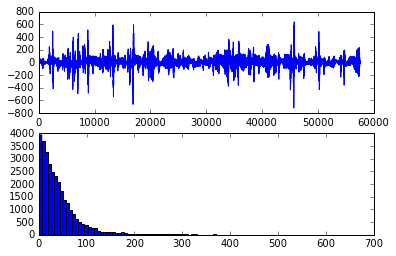

In [19]:
feat = net.blobs['conv1/7x7_s2'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

<img src="netblob.png"
style="width:550px;height:630px;float:left">

#### Backward for one time

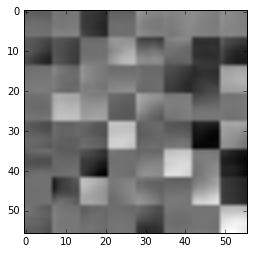

In [20]:
net.backward()
imshow(net.params['conv1/7x7_s2'][0].diff.reshape(8, 8, 7, 7)
       .transpose(0, 2, 1, 3).reshape(8*7, 8*7), cmap='gray');

#### Define the solver

In [5]:
from caffe.proto import caffe_pb2
solver_param = caffe_pb2.SolverParameter()
solver_param.net = sample_netparam

solver_param.test_interval = 1000
solver_param.test_iter.append(18)

solver_param.iter_size = 1
solver_param.max_iter = 200000
solver_param.type = 'SGD'
solver_param.base_lr = 0.0002
solver_param.lr_policy = 'step'
solver_param.gamma = 0.5
solver_param.stepsize = 2000
solver_param.momentum = 0.9
solver_param.weight_decay = 2e-5
solver_param.display = 40
solver_param.snapshot = 2000
solver_param.snapshot_prefix = "./finetune_prefix/prefix"
solver_param.solver_mode = caffe_pb2.SolverParameter.GPU
# Write the solver to a temporary file and return its filename.
#with open('finetune_solver.prototxt','w') as solver_f :
#    solver_f.write(str(solver_param))
with tempfile.NamedTemporaryFile(delete=False) as solver_f:
    solver_f.write(str(solver_param))
print solver_f.name

/tmp/tmpSrDW3C


In [6]:
!cat /tmp/tmpdxJola

test_iter: 18
test_interval: 1000
base_lr: 0.0002
display: 40
max_iter: 200000
lr_policy: "step"
gamma: 0.5
momentum: 0.9
weight_decay: 2e-05
stepsize: 2000
snapshot: 2000
snapshot_prefix: "./finetune_prefix/prefix"
solver_mode: GPU
net: "train_val_inception_3b.prototxt"
iter_size: 1
type: "SGD"


#### load the solver and create train and test nets

In [8]:
solver = None
solver = caffe.SGDSolver(solver_f.name)
#solver.net.copy_from(net)

#### Begin to finetune

In [9]:
%%time
niter = 200
test_interval = 40
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 1, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1/7x7_s2')
    output[it] = solver.test_nets[0].blobs['accuracy'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(18):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['accuracy'].data
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 40 testing...
Iteration 80 testing...
Iteration 120 testing...
Iteration 160 testing...
CPU times: user 2h 37min 2s, sys: 5min 4s, total: 2h 42min 7s
Wall time: 10min 10s


##  3 The rest
from .classifier import Classifier
from .detector import Detector
from . import io

In [10]:
dir(caffe.io)

['Transformer',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'array_to_blobproto',
 'array_to_datum',
 'arraylist_to_blobprotovecor_str',
 'blobproto_to_array',
 'blobprotovector_str_to_arraylist',
 'caffe_pb2',
 'datum_to_array',
 'load_image',
 'np',
 'oversample',
 'resize',
 'resize_image',
 'skimage',
 'zoom']

In [ ]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR